In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
import sys
sys.path.append('..')

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert cylindrical to rectangular
R, phi, z = rect_to_cyl(samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vR, vT, vz = rect_to_cyl_vec(samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5], samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
samples_qdf = np.stack((R, phi, z, vR, vT, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (R)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (phi)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vR)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vT)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))

c:\users\ayush\anaconda3\lib\site-packages\astropy\coordinates\sky_coordinate.py:1786: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

#stars 1699708
min/max/mean (R) 7.800911997788074 8.799620277350543 8.291940989763331
min/max/mean (phi) 3.0813469383936956 3.201835260171212 3.141300302894571
min/max/mean (z) -0.47224099228924643 0.5251864323212104 0.020554162071444157
min/max/mean (vR) -226.5417324492553 236.49705257869675 0.007393815901521288
min/max/mean (vT) 18.03771310630137 300.64400115120344 200.92571250021766
min/max/mean (vz) -78.63184750506196 79.49529776718326 -0.001518106057358567


In [2]:
#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-06-25 - Updated - Ayush Pandhi
    """
    #Scaling velocities with standard deviation
    inputs_std = np.nanstd(inputs, axis=0)
    inputs = inputs/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    IQR = iqr(inputs)
    A = min(np.std(inputs), IQR/1.34)
    bw = 1.059 * A * N ** (-1/5.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-06-25 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = samples/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_qdf_epanechnikov = generate_KDE(samples_qdf, 'epanechnikov')

"\n#Generate kde for 2*Scotts bandwidth to compare\nkde_qdf_gaussian2 = generate_KDE2(samples_qdf, 'gaussian')\nkde_qdf_tophat2 = generate_KDE2(samples_qdf, 'tophat')\nkde_qdf_epanechnikov2 = generate_KDE2(samples_qdf, 'epanechnikov')\nkde_qdf_exponential2 = generate_KDE2(samples_qdf, 'exponential')\nkde_qdf_linear2 = generate_KDE2(samples_qdf, 'linear')\nkde_qdf_cosine2 = generate_KDE2(samples_qdf, 'cosine')\n\n#Generate kde for 3*Scotts bandwidth to compare\nkde_qdf_gaussian3 = generate_KDE3(samples_qdf, 'gaussian')\nkde_qdf_tophat3 = generate_KDE3(samples_qdf, 'tophat')\nkde_qdf_epanechnikov3 = generate_KDE3(samples_qdf, 'epanechnikov')\nkde_qdf_exponential3 = generate_KDE3(samples_qdf, 'exponential')\nkde_qdf_linear3 = generate_KDE3(samples_qdf, 'linear')\nkde_qdf_cosine3 = generate_KDE3(samples_qdf, 'cosine')\n"

In [4]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(samples_qdf[:,0])
mean_phi = np.ones((N, 1))*np.mean(samples_qdf[:,1])
mean_z = np.ones((N, 1))*np.mean(samples_qdf[:,2])
mean_vR = np.ones((N, 1))*np.mean(samples_qdf[:,3])
mean_vT = np.ones((N, 1))*np.mean(samples_qdf[:,4])
mean_vz = np.ones((N, 1))*np.mean(samples_qdf[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(samples_qdf[:,0]), max(samples_qdf[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(samples_qdf[:,1]), max(samples_qdf[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(samples_qdf[:,2]), max(samples_qdf[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(samples_qdf[:,3]), max(samples_qdf[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(samples_qdf[:,4]), max(samples_qdf[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(samples_qdf[:,5]), max(samples_qdf[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

Plots for variable R at Scotts bw


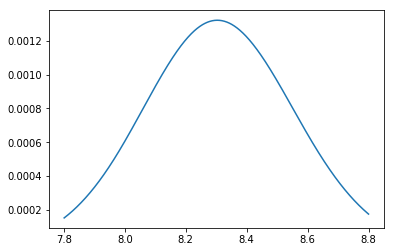

In [6]:
#Variable R plot
print('Variable R at Scotts bw')

Rplot_epanechnikov = kde_qdf_epanechnikov(sample_R)
plt.plot(R_points, Rplot_epanechnikov)

Variable phi at Scotts bw


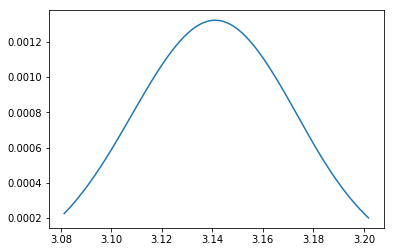

In [7]:
#Variable phi plot
print('Variable phi at Scotts bw')

phiplot_epanechnikov = kde_qdf_epanechnikov(sample_phi)
plt.plot(phi_points, phiplot_epanechnikov)

Variable z at Scotts bw


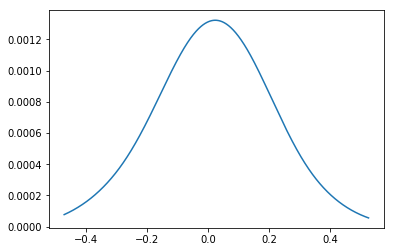

In [8]:
#Variable z plot
print('Variable z at Scotts bw')

zplot_epanechnikov = kde_qdf_epanechnikov(sample_z)
plt.plot(z_points, zplot_epanechnikov)

Variable vR at Scotts bw


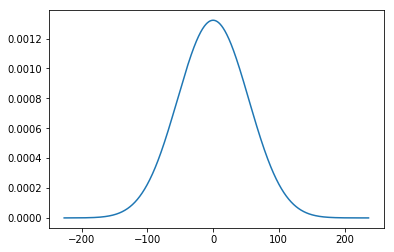

In [9]:
#Variable vR plot
print('Variable vR at Scotts bw')

vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov)

Variable vT at Scotts bw


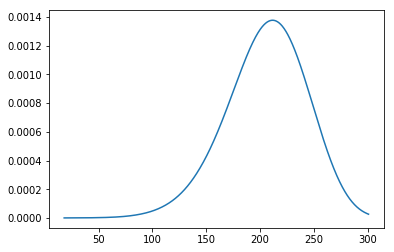

In [10]:
#Variable vT plot
print('Variable vT at Scotts bw')

vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov)

Variable vz at Scotts bw


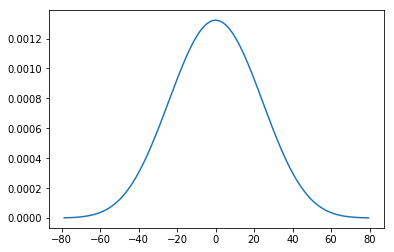

In [11]:
#Variable vz plot
print('Variable vz at Scotts bw')

vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov)

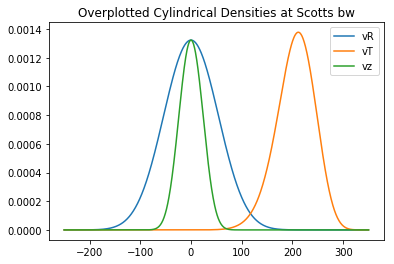

In [13]:
#For variable vR
vR_points = np.linspace(-250, 350, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-250, 350, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-250, 350, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov, label='vR')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov, label='vT')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov, label='vz')

#Show plot
plt.title('Overplotted Cylindrical Densities at Scotts bw')
plt.legend()
plt.show()